In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
from bempp.api.linalg import lu
bempp.core.opencl_kernels.set_default_device(0,0)

In [104]:
k = 3.25
h = 0.1
deg = 5

d0 = [0,0,-1] # wave's travel direction
p0 = [1,0,0] # polarization 

In [82]:
rotation_angle = np.pi/9
rotation_mat = [[1,0,0],[0, np.cos(rotation_angle), -np.sin(rotation_angle)],[0,np.sin(rotation_angle), np.cos(rotation_angle)]]

In [83]:
origin_grid1 = bempp.api.shapes.sphere(r = 0.2, origin=[-0.3,0,0],h = h)
origin_grid_vert1 = origin_grid1.vertices

grid_vert1 = np.zeros((3, origin_grid_vert1.shape[1]))
for i in range(grid_vert1.shape[1]):
    grid_vert1[:,i] = rotation_mat @ origin_grid_vert1[:,i]
    
grid1 = bempp.api.Grid(grid_vert1, origin_grid1.elements)
#=======================================================================
origin_grid2 = bempp.api.shapes.sphere(r = 0.2, origin=[0.3,0,0],h = h)
origin_grid_vert2 = origin_grid2.vertices

grid_vert2 = np.zeros((3, origin_grid_vert2.shape[1]))
for i in range(grid_vert2.shape[1]):
    grid_vert2[:,i] = rotation_mat @ origin_grid_vert2[:,i]
    
grid2 = bempp.api.Grid(grid_vert2, origin_grid2.elements)
#=======================================================================
grid_combined = bempp.api.grid.grid.union([grid1,grid2])

In [84]:
div_space1 = bempp.api.function_space(grid1, "RWG", 0)
curl_space1 = bempp.api.function_space(grid1, "SNC", 0)

div_space2 = bempp.api.function_space(grid2, "RWG", 0)
curl_space2 = bempp.api.function_space(grid2, "SNC", 0)

div_space_combined = bempp.api.function_space(grid_combined, "RWG", 0)
curl_space_combined = bempp.api.function_space(grid_combined, "SNC", 0)

In [85]:
origin_unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
origin_vert_unit_sphere = origin_unit_sphere.vertices

vert_unit_sphere = np.zeros((3, origin_vert_unit_sphere.shape[1]))
for i in range(vert_unit_sphere.shape[1]):
    vert_unit_sphere[:,i] = rotation_mat@origin_vert_unit_sphere[:,i]
    
unit_sphere = bempp.api.Grid(vert_unit_sphere,origin_unit_sphere.elements)
    
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

In [86]:
bempp.api.export('origin_sphere.msh', grid = grid1)
#bempp.api.export('rotated_sphere.msh', grid = unit_sphere)

In [105]:
elec1 = bempp.api.operators.boundary.maxwell.electric_field(div_space1, div_space1, curl_space1, k)
elec_far1 = bempp.api.operators.far_field.maxwell.electric_field(div_space1, vert_unit_sphere, k)

elec2 = bempp.api.operators.boundary.maxwell.electric_field(div_space2, div_space2, curl_space2, k)
elec_far2 = bempp.api.operators.far_field.maxwell.electric_field(div_space2, vert_unit_sphere, k)

elec_combined = bempp.api.operators.boundary.maxwell.electric_field(div_space_combined, div_space_combined, curl_space_combined, k)
elec_far_combined = bempp.api.operators.far_field.maxwell.electric_field(div_space_combined, vert_unit_sphere, k)

mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere, space_unit_sphere, space_unit_sphere).weak_form().A

In [88]:
def sph_b(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*k*r))*scipy.special.jv(q+0.5, k*r)  

def sph_b_dr(q,x):
    r = np.linalg.norm(x)
    return k*(sph_b(q-1,x) - ((q+1)/(k*r))*sph_b(q,x))

def sph(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)
    
def sph_dazi(p, q, x):
    return 1j * p * sph(p, q, x)

def sph_dpolar(p, q, x):
    polar = np.arccos(x[2]/np.linalg.norm(x))
    azimuth = np.arctan2(x[1],x[0])
    y1 = sph(p, q, x)
    y3 = sph(-p, q, x)
    
    if abs(p) == q and p >= 0:
        return (p / np.tan(polar)) * y1 
    elif abs(p) != q and p >= 0:
        y2 = sph(p + 1, q, x)
        return (p / np.tan(polar)) * y1 - np.sqrt((q - p) * (q + p + 1)) * np.exp(-1j * azimuth) * y2
    elif abs(p) == q and p < 0:
        return ((-1)**p) * (-p / np.tan(polar)) * y3 * np.exp(1j*2*p*azimuth)
    elif abs(p) != q and p < 0:
        y4 = sph(-p + 1, q, x)
        return  ((-1)**p) * ((-p / np.tan(polar)) * y3 - np.sqrt((q - (-p)) * (q + (-p) + 1)) * np.exp(-1j * azimuth) * y4) * np.exp(1j*2*p*azimuth)

In [89]:
def sph_wf_M(p,q,x):
    r = np.linalg.norm(x)
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/r)
    
    grad_sph = [sph_dpolar(p,q,x)*np.cos(polar)*np.cos(azimuth) - sph_dazi(p,q,x)*np.sin(azimuth)/np.sin(polar), 
                sph_dpolar(p,q,x)*np.cos(polar)*np.sin(azimuth) + sph_dazi(p,q,x)*np.cos(azimuth)/np.sin(polar),
               -sph_dpolar(p,q,x)*np.sin(polar)]
    hat_x = [np.sin(polar)*np.cos(azimuth), np.sin(polar)*np.sin(azimuth), np.cos(polar)]
    
    return sph_b(q,x)*np.cross(grad_sph, hat_x)

def sph_wf_N(p,q,x):
    r = np.linalg.norm(x)
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/r)
    
    grad_sph = [sph_dpolar(p,q,x)*np.cos(polar)*np.cos(azimuth) - sph_dazi(p,q,x)*np.sin(azimuth)/np.sin(polar), 
                sph_dpolar(p,q,x)*np.cos(polar)*np.sin(azimuth) + sph_dazi(p,q,x)*np.cos(azimuth)/np.sin(polar),
               -sph_dpolar(p,q,x)*np.sin(polar)]
    hat_x = [np.sin(polar)*np.cos(azimuth), np.sin(polar)*np.sin(azimuth), np.cos(polar)]
    
    
    part_1 = [(q*(q+1)/r)*sph_b(q,x)*sph(p,q,x)*hat_x[0], 
             (q*(q+1)/r)*sph_b(q,x)*sph(p,q,x)*hat_x[1], 
             (q*(q+1)/r)*sph_b(q,x)*sph(p,q,x)*hat_x[2]]
    
    part_2 = [(1/r)*(sph_b(q,x)+r*sph_b_dr(q,x))*grad_sph[0], 
                (1/r)*(sph_b(q,x)+r*sph_b_dr(q,x))*grad_sph[1],
               (1/r)*(sph_b(q,x)+r*sph_b_dr(q,x))*grad_sph[2]]
    
    return [(1/(1j*k))*(part_1[0]+part_2[0]), (1/(1j*k))*(part_1[1]+part_2[1]), (1/(1j*k))*(part_1[2]+part_2[2])]

In [90]:
def U_pq(p, q, x):
    r = np.linalg.norm(x)
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/r)
    
    return [sph_dpolar(p,q,x)*np.cos(polar)*np.cos(azimuth) - sph_dazi(p,q,x)*np.sin(azimuth)/np.sin(polar), 
            sph_dpolar(p,q,x)*np.cos(polar)*np.sin(azimuth) + sph_dazi(p,q,x)*np.cos(azimuth)/np.sin(polar),
            -sph_dpolar(p,q,x)*np.sin(polar)]
def V_pq(p, q, x):
    r = np.linalg.norm(x)
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/r)
    
    grad_sph = [sph_dpolar(p,q,x)*np.cos(polar)*np.cos(azimuth) - sph_dazi(p,q,x)*np.sin(azimuth)/np.sin(polar), 
                sph_dpolar(p,q,x)*np.cos(polar)*np.sin(azimuth) + sph_dazi(p,q,x)*np.cos(azimuth)/np.sin(polar),
               -sph_dpolar(p,q,x)*np.sin(polar)]
    hat_x = [np.sin(polar)*np.cos(azimuth), np.sin(polar)*np.sin(azimuth), np.cos(polar)]
    
    return np.cross(hat_x, grad_sph)

In [106]:
coeff_S_V_1 = []
coeff_S_U_1 = []
for q in range(1, deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def V_fun_1(x,n,domain_index,result):
            with objmode():
                result[0] = V_pq(p,q,x)[0]
        V_grid_1 = bempp.api.GridFunction(space_unit_sphere,fun = V_fun_1)
        coeff_S_V_1.append(np.conj(V_grid_1.coefficients)* (-k) *((1j)**(q+1))/(q*(q+1)))
        
        @bempp.api.complex_callable
        def U_fun_1(x,n,domain_index,result):
            with objmode():
                result[0] = U_pq(p,q,x)[0]
        U_grid_1 = bempp.api.GridFunction(space_unit_sphere,fun = U_fun_1)
        coeff_S_U_1.append(np.conj(U_grid_1.coefficients)* ((1j)**q)/(q*(q+1)))

In [107]:
%store -r coeff_S_V_2
%store -r coeff_S_U_2

%store -r coeff_S_V_3
%store -r coeff_S_U_3

%store -r coeff_S_tilde_M1
%store -r coeff_S_tilde_N1

%store -r coeff_S_tilde_M2
%store -r coeff_S_tilde_N2

%store -r coeff_S_tilde_M_combined
%store -r coeff_S_tilde_N_combined

In [108]:
t1_MM = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t1_MM[i,j] = coeff_S_tilde_M1[j][0,:]@mass_mat@coeff_S_V_1[i] + coeff_S_tilde_M1[j][1,:]@mass_mat@coeff_S_V_2[i] + coeff_S_tilde_M1[j][2,:]@mass_mat@coeff_S_V_3[i]
        
t1_MN = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t1_MN[i,j] = coeff_S_tilde_N1[j][0,:]@mass_mat@coeff_S_V_1[i] + coeff_S_tilde_N1[j][1,:]@mass_mat@coeff_S_V_2[i] + coeff_S_tilde_N1[j][2,:]@mass_mat@coeff_S_V_3[i]
        
t1_NM = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t1_NM[i,j] = coeff_S_tilde_M1[j][0,:]@mass_mat@coeff_S_U_1[i] + coeff_S_tilde_M1[j][1,:]@mass_mat@coeff_S_U_2[i] + coeff_S_tilde_M1[j][2,:]@mass_mat@coeff_S_U_3[i]
        
t1_NN = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t1_NN[i,j] = coeff_S_tilde_N1[j][0,:]@mass_mat@coeff_S_U_1[i] + coeff_S_tilde_N1[j][1,:]@mass_mat@coeff_S_U_2[i] + coeff_S_tilde_N1[j][2,:]@mass_mat@coeff_S_U_3[i]

In [109]:
t2_MM = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t2_MM[i,j] = coeff_S_tilde_M2[j][0,:]@mass_mat@coeff_S_V_1[i] + coeff_S_tilde_M2[j][1,:]@mass_mat@coeff_S_V_2[i] + coeff_S_tilde_M2[j][2,:]@mass_mat@coeff_S_V_3[i]
        
t2_MN = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t2_MN[i,j] = coeff_S_tilde_N2[j][0,:]@mass_mat@coeff_S_V_1[i] + coeff_S_tilde_N2[j][1,:]@mass_mat@coeff_S_V_2[i] + coeff_S_tilde_N2[j][2,:]@mass_mat@coeff_S_V_3[i]
        
t2_NM = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t2_NM[i,j] = coeff_S_tilde_M2[j][0,:]@mass_mat@coeff_S_U_1[i] + coeff_S_tilde_M2[j][1,:]@mass_mat@coeff_S_U_2[i] + coeff_S_tilde_M2[j][2,:]@mass_mat@coeff_S_U_3[i]
        
t2_NN = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t2_NN[i,j] = coeff_S_tilde_N2[j][0,:]@mass_mat@coeff_S_U_1[i] + coeff_S_tilde_N2[j][1,:]@mass_mat@coeff_S_U_2[i] + coeff_S_tilde_N2[j][2,:]@mass_mat@coeff_S_U_3[i]

In [110]:
t3_MM = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t3_MM[i,j] = coeff_S_tilde_M_combined[j][0,:]@mass_mat@coeff_S_V_1[i] + coeff_S_tilde_M_combined[j][1,:]@mass_mat@coeff_S_V_2[i] + coeff_S_tilde_M_combined[j][2,:]@mass_mat@coeff_S_V_3[i]
        
t3_MN = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t3_MN[i,j] = coeff_S_tilde_N_combined[j][0,:]@mass_mat@coeff_S_V_1[i] + coeff_S_tilde_N_combined[j][1,:]@mass_mat@coeff_S_V_2[i] + coeff_S_tilde_N_combined[j][2,:]@mass_mat@coeff_S_V_3[i]
        
t3_NM = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t3_NM[i,j] = coeff_S_tilde_M_combined[j][0,:]@mass_mat@coeff_S_U_1[i] + coeff_S_tilde_M_combined[j][1,:]@mass_mat@coeff_S_U_2[i] + coeff_S_tilde_M_combined[j][2,:]@mass_mat@coeff_S_U_3[i]
        
t3_NN = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t3_NN[i,j] = coeff_S_tilde_N_combined[j][0,:]@mass_mat@coeff_S_U_1[i] + coeff_S_tilde_N_combined[j][1,:]@mass_mat@coeff_S_U_2[i] + coeff_S_tilde_N_combined[j][2,:]@mass_mat@coeff_S_U_3[i]

In [111]:
T_matrix1 = np.block([
    [t1_MM, t1_MN],
    [t1_NM, t1_NN]
])

T_matrix2 = np.block([
    [t2_MM, t2_MN],
    [t2_NM, t2_NN]
])

T_matrix3 = np.block([
    [t3_MM, t3_MN],
    [t3_NM, t3_NN]
])

S_matrix1 = np.identity(T_matrix1.shape[1]) + 2 * T_matrix1
S_matrix2 = np.identity(T_matrix2.shape[1]) + 2 * T_matrix2
S_matrix3 = np.identity(T_matrix3.shape[1]) + 2 * T_matrix3

In [112]:
rhs_value =  np.log(np.linalg.det(S_matrix3))-(np.log(np.linalg.det(S_matrix1)) + np.log(np.linalg.det(S_matrix2)))
print(rhs_value, rhs_value*3.25)

(0.012874086102060533+0.02681093043146454j) (0.041840779831696734+0.08713552390225976j)


In [ ]:
# h = 0.05
# k = 0.125 (3.7384926886666493e-06-4.7673682342355066e-08j) (4.6731158608333116e-07-5.959210292794383e-09j)
# k = 0.25 (1.5343504264053384e-05-1.1253277376686421e-07j) (3.835876066013346e-06-2.8133193441716052e-08j)
# k = 0.375 (3.584907622517994e-05+1.0939652846069913e-06j) (1.3443403584442477e-05+4.1023698172762174e-07j)
# k = 0.5 (6.654673426176316e-05+7.296142180312614e-06j) (3.327336713088158e-05+3.648071090156307e-06j)
# k = 0.625 (0.00010839493038442005+2.5451438192068687e-05j) (6.774683149026253e-05+1.590714887004293e-05j)
# k = 0.75 (0.00016130319983459485+6.609329055497389e-05j) (0.00012097739987594613+4.9569967916230414e-05j)
# k = 0.875 (0.00022339405912540078+0.00014314614332573347j) (0.00019546980173472568+0.0001252528754100168j)
# k = 1 (0.000290364785855049+0.0002731961181349357j) (0.000290364785855049+0.0002731961181349357j)

# k = 1.125 (0.0003550839733900968+0.0004742619090203487j) (0.0003994694700638589+0.0005335446476478923j)
# k = 1.25 (0.0004075636804910382+0.0007641718209929066j) (0.0005094546006137977+0.0009552147762411332j)
# k = 1.375 (0.00043544657029545575+0.001158712006048751j) (0.0005987390341562517+0.0015932290083170327j)
# k = 1.5 (0.00042513770943874984+0.0016697666955169943j) (0.0006377065641581248+0.0025046500432754915j)
# k = 1.625 (0.0003636909868363625+0.0023037235734661154j) (0.000590997853609089+0.0037435508068824376j)
# k = 1.75 (0.00024152772723498583+0.0030604669968931353j) (0.0004226735226612252+0.005355817244562987j)
# k = 1.875 (5.6016181346069116e-05+0.003933329044657069j) (0.00010503034002387959+0.007374991958732004j)
# k = 2 (-0.00018412991951161084+0.004910412875042319j) (-0.0003682598390232217+0.009820825750084639j)

# k= 2.125 (-0.0004537741065164802+0.005977742034251665j) (-0.0009642699763475204+0.012702701822784788j)
# k = 2.25 (-0.0007058760855078727+0.0071247170674627325j) (-0.0015882211923927136+0.016030613401791148j)
# k = 2.375 (-0.000866061231677151+0.008352365043516552j) (-0.0020568954252332336+0.01983686697835181j)
# k = 2.5 (-0.0008279284198234316+0.009684827071412938j) (-0.002069821049558579+0.024212067678532345j)
# k = 2.625 (-0.0004500753765176446+0.011184408487051767j) (-0.0011814478633588171+0.029359072278510888j)
# k = 2.75 (0.0004438385080736684+0.012970263456289599j) (0.0012205558972025882+0.0356682245047964j)
# k = 2.875 (0.002060317999004302+0.015240329855115642j) (0.005923414247137368+0.04381594833345747j)
# k = 3 (0.004624587933679591+0.018295391552823337j) (0.013873763801038774+0.05488617465847001j)

# k = 3.125 (0.008360454669783302+0.02256305624425403j) (0.026126420843072817+0.07050955076329385j)

# func_value = [-5.959210292794383e-09j, -2.8133193441716052e-08j, 4.1023698172762174e-07j, 3.648071090156307e-06j, 1.590714887004293e-05j, 
#                4.9569967916230414e-05j, 0.0001252528754100168j, 0.0002731961181349357j, 0.0005335446476478923j, 0.0009552147762411332j, 
#                0.0015932290083170327j, 0.0025046500432754915j, 0.0037435508068824376j, 0.005355817244562987j, 0.007374991958732004j,
#                0.009820825750084639j, 0.012702701822784788j, 0.016030613401791148j, 0.01983686697835181j, 0.024212067678532345j, 
#                0.029359072278510888j, 0.0356682245047964j, 0.04381594833345747j, 0.05488617465847001j]

In [ ]:
# h = 0.1 
# k = 0.125 (3.3172020819767717e-06-4.2158529511042095e-08j) (4.1465026024709647e-07-5.269816188880262e-09j)
# k = 0.25 (1.3628069552276169e-05-8.809919499193179e-08j) (3.407017388069042e-06-2.2024798747982948e-08j)
# k = 0.375 (3.188489709043778e-05+1.0683700953370914e-06j) (1.1956836408914167e-05+4.006387857514093e-07j)
# k = 0.5 (5.927230498989182e-05+6.889945047328962e-06j) (2.963615249494591e-05+3.444972523664481e-06j)
# k = 0.625 (9.665760866938919e-05+2.383282053515859e-05j) (6.041100541836824e-05+1.4895512834474118e-05j)
# k = 0.75 (0.00014392627072646463+6.166095933372341e-05j) (0.00010794470304484848+4.624571950029256e-05j)
# k = 0.875 (0.00019929978842331275+0.0001332696082264953j) (0.00017438731487039866+0.00011661090719818339j)
# k = 1  (0.00025875123652710497+0.0002540033844689836j) (0.00025875123652710497+0.0002540033844689836j)

# k = 1.125 (0.0003156453388115238+0.0004405116203807097j) (0.00035510100616296426+0.0004955755729282984j)
# k = 1.25 (0.00036073487286142347+0.0007092414699572669j) (0.00045091859107677934+0.0008865518374465836j)
# k = 1.375 (0.00038264287348292736+0.001074725039364094j) (0.0005261339510390251+0.0014777469291256291j)
# k = 1.5 (0.00036894960366171126+0.0015478691875962791j) (0.0005534244054925669+0.0023218037813944187j)
# k = 1.625 (0.00030798309726609574+0.0021345053410666837j) (0.0005004725330574056+0.003468571179233361j)
# k = 1.75 (0.0001913799164325325+0.0028345018972690955j) (0.00033491485375693186+0.004960378320220917j)
# k = 1.875 (1.7435350820188544e-05+0.0036417836608123033j) (3.269128278785352e-05+0.006828344364023069j)
# k = 2  (-0.0002048046071528309+0.0045456404795563565j) (-0.0004096092143056618+0.009091280959112713j)

# k = 2.125 (-0.00045084876197065693+0.005533738265307203j) (-0.000958053619187646+0.011759193813777807j)
# k = 2.25 (-0.0006757254270393087+0.006597264337255632j) (-0.0015203822108384446+0.014843844758825171j)
# k = 2.375 (-0.000809028419028579+0.007738635142841066j) (-0.0019214424951928752+0.018379258464247532j)
# k = 2.5 (-0.00075067110969812+0.008982149959631536j) (-0.0018766777742453+0.02245537489907884j)
# k = 2.625 (-0.0003682272947297949+0.01038786012994991j) (-0.0009665966486657115+0.027268132841118516j)
# k = 2.75 (0.0005029705294387621+0.01206869625211704j) (0.0013831689559565957+0.03318891469332186j)
# k = 2.875 (0.0020555023757350965+0.014210496892131996j) (0.0059095693302384025+0.04085517856487949j)
# k = 3  (0.004499581955164422+0.017093943624410524j) (0.013498745865493267+0.05128183087323157j)

# k = 3.125 (0.00804504027673969+0.02111646758164004j) (0.02514075086481153+0.06598896119262512j)
# k = 3.25 (0.012874086102060533+0.02681093043146454j) (0.041840779831696734+0.08713552390225976j)


# func_value = [-5.269816188880262e-09j, -2.2024798747982948e-08j,4.006387857514093e-07j, 3.444972523664481e-06j,1.4895512834474118e-05j, 4.624571950029256e-05j,0.00011661090719818339j, 
#              0.0002540033844689836j,0.0004955755729282984j, 0.0008865518374465836j, 0.0014777469291256291j,
#                0.0023218037813944187j,0.003468571179233361j, 0.004960378320220917j, 0.006828344364023069j, 0.009091280959112713j,0.011759193813777807j, 0.014843844758825171j, 0.018379258464247532j, 
#              0.02245537489907884j,0.027268132841118516j, 0.03318891469332186j, 0.04085517856487949j, 0.05128183087323157j]
# k = 4  (0.06515634459690467+0.1418674697268386j) (0.2606253783876187+0.5674698789073545j)

In [126]:
func_value_005 =  [0j, -5.959210292794383e-09j, -2.8133193441716052e-08j, 4.1023698172762174e-07j, 3.648071090156307e-06j, 1.590714887004293e-05j, 
               4.9569967916230414e-05j, 0.0001252528754100168j, 0.0002731961181349357j, 0.0005335446476478923j, 0.0009552147762411332j, 
                0.0015932290083170327j, 0.0025046500432754915j, 0.0037435508068824376j, 0.005355817244562987j, 0.007374991958732004j,
                0.009820825750084639j, 0.012702701822784788j, 0.016030613401791148j, 0.01983686697835181j, 0.024212067678532345j, 
                0.029359072278510888j, 0.0356682245047964j, 0.04381594833345747j, 0.05488617465847001j]

func_value_01 = [0j, -5.269816188880262e-09j, -2.2024798747982948e-08j,4.006387857514093e-07j, 3.444972523664481e-06j,1.4895512834474118e-05j, 4.624571950029256e-05j,0.00011661090719818339j, 
             0.0002540033844689836j,0.0004955755729282984j, 0.0008865518374465836j, 0.0014777469291256291j,
                0.0023218037813944187j,0.003468571179233361j, 0.004960378320220917j, 0.006828344364023069j, 0.009091280959112713j,0.011759193813777807j, 0.014843844758825171j, 0.018379258464247532j, 
              0.02245537489907884j,0.027268132841118516j, 0.03318891469332186j, 0.04085517856487949j, 0.05128183087323157j]
points = [0, 0.125,0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2, 2.125, 2.25, 2.375, 2.5, 2.625, 2.75, 2.875,3]

In [127]:
np.imag(np.trapz(func_value_01, points))

0.0280445800320058

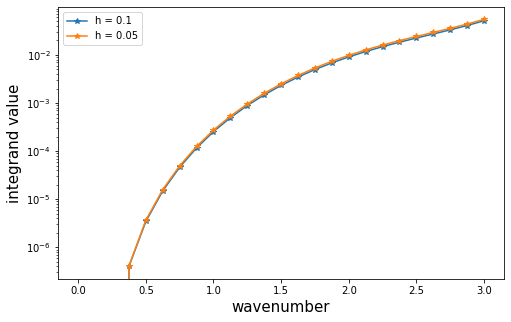

In [134]:
plt.figure(figsize = [8,5])
plt.semilogy(points, np.imag(func_value_01), '*-')
plt.semilogy(points, np.imag(func_value_005), '*-')

plt.xlabel('wavenumber', fontsize = 15)
plt.ylabel('integrand value', fontsize = 15)
plt.legend(['h = 0.1', 'h = 0.05'])
plt.savefig('integrand value_maxwell case to prove the equality.pdf')

In [120]:
k = 3.25
op11 = bempp.api.operators.boundary.maxwell.electric_field(div_space1, div_space1, curl_space1, k)
op22 = bempp.api.operators.boundary.maxwell.electric_field(div_space2, div_space2, curl_space2, k)
op21 = bempp.api.operators.boundary.maxwell.electric_field(div_space1, div_space2, curl_space2, k)
op12 = bempp.api.operators.boundary.maxwell.electric_field(div_space2, div_space1, curl_space1, k)

mat11 = op11.weak_form().A
mat12 = op12.weak_form().A
mat21 = op21.weak_form().A
mat22 = op22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])    
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

combined = np.linalg.inv(mat2).dot(mat)
print(np.log(np.linalg.det(combined)))
print(f'the imaginary part is :{np.imag(np.log(np.linalg.det(combined)))}')

(-0.030805484210492645+0.03720752072060614j)
the imaginary part is :0.03720752072060614


In [80]:
(np.imag(np.log(np.linalg.det(combined))) - np.imag(np.trapz(func_value_005, points)))/np.imag(np.log(np.linalg.det(combined)))

-0.14374300847600632

In [116]:
(np.imag(np.log(np.linalg.det(combined))) - np.imag(np.trapz(func_value_01, points)))/np.imag(np.log(np.linalg.det(combined)))

-0.20793549218293547

In [38]:
for index, point in enumerate(np.arange(0.125, 3.125, 0.125)):
    
    k = point
    op11 = bempp.api.operators.boundary.maxwell.electric_field(div_space1, div_space1, curl_space1, k)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(div_space2, div_space2, curl_space2, k)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(div_space1, div_space2, curl_space2, k)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(div_space2, div_space1, curl_space1, k)

    mat11 = op11.weak_form().A
    mat12 = op12.weak_form().A
    mat21 = op21.weak_form().A
    mat22 = op22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])    
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    combined = np.linalg.inv(mat2).dot(mat)
    
    logdet_ = np.imag(np.log(np.linalg.det(combined)))
    _005 =  np.imag(np.trapz(func_value_005[0:index+2], points[0:index+2]))
    print(f'the imaginary part is :{logdet_}', _005, (logdet_ - _005)/logdet_)

the imaginary part is :-2.099745248855549e-07 -3.7245064329964895e-10 0.99822621032955
the imaginary part is :-1.862734066671788e-06 -2.503225876706551e-09 0.9986561549920118
the imaginary part is :-7.268898623523418e-06 2.1378260891162555e-08 1.0029410591615597
the imaginary part is :-2.0260380715516742e-05 2.750225153839081e-07 1.0135744001677756
the imaginary part is :-4.6434052231006876e-05 1.4972237628963604e-06 1.0322440900795768
the imaginary part is :-9.282696498087888e-05 5.589543562038444e-06 1.0602146538259634
the imaginary part is :-0.0001669168894964097 1.6515971269928895e-05 1.0989472744175726
the imaginary part is :-0.00027490727846095554 4.141903336648842e-05 1.1506654665470093
the imaginary part is :-0.0004193310462517757 9.184033122791517e-05 1.2190162928522403
the imaginary part is :-0.0005960898361927454 0.00018488779522097927 1.3101676693598174
the imaginary part is :-0.0007911318766864079 0.0003441655317558646 1.4350292813347054
the imaginary part is :-0.000977059

In [43]:
for index, point in enumerate(np.arange(0.125, 3.125, 0.125)):
    
    k = point
    op11 = bempp.api.operators.boundary.maxwell.electric_field(div_space1, div_space1, curl_space1, k)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(div_space2, div_space2, curl_space2, k)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(div_space1, div_space2, curl_space2, k)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(div_space2, div_space1, curl_space1, k)

    mat11 = op11.weak_form().A
    mat12 = op12.weak_form().A
    mat21 = op21.weak_form().A
    mat22 = op22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])    
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    combined = np.linalg.inv(mat2).dot(mat)
    
    logdet_ = np.imag(np.log(np.linalg.det(combined)))
    _01 = np.imag(np.trapz(func_value_01[0:index+2], points[0:index+2]))
    print(f'the imaginary part is :{logdet_}', _01, (logdet_ - _01)/logdet_)

the imaginary part is :-1.8677814030157468e-07 -3.2936351180501636e-10 0.9982366056794804
the imaginary part is :-1.6636736146057663e-06 -2.035276945358967e-09 0.9987766368790785
the imaginary part is :-6.52432770865778e-06 2.162809724235518e-08 1.0033149924725049
the imaginary part is :-1.8269421977090878e-05 2.619788040808483e-07 1.0143397423525145
the imaginary part is :-4.202797582775965e-05 1.4082591389645108e-06 1.033507660343574
the imaginary part is :-8.424872167513763e-05 5.229586159887428e-06 1.0620731811225892
the imaginary part is :-0.00015176308593566978 1.5408125328542173e-05 1.1015274909148425
the imaginary part is :-0.0002501826832665963 3.857151855774011e-05 1.1541734146189409
the imaginary part is :-0.00038166491782433355 8.542020339507024e-05 1.2238094186963917
the imaginary part is :-0.0005421574153594335 0.00017180316654350037 1.316887976953336
the imaginary part is :-0.0007183127641150328 0.00031957183945426364 1.4448923302204975
the imaginary part is :-0.00088434

In [121]:
err_005 = [0.99822621032955, 0.9986561549920118, 1.0029410591615597, 1.0135744001677756, 1.0322440900795768, 1.0602146538259634, 1.0989472744175726,
           1.1506654665470093, 1.2190162928522403, 1.3101676693598174, 1.4350292813347054, 1.6143772679913841, 1.8925757405825065, 2.3831687244309183,
           3.4869492368920825, 8.340282621835106, 10.282705799063804, 2.552175180437652, 1.233074997565047, 0.6948968696664168, 0.4122712922618254,
           0.25031688913513334, 0.1612127177252819, 0.126931269703906]

err_01 = [0.9982366056794804, 0.9987766368790785, 1.0033149924725049, 1.0143397423525145, 1.033507660343574, 1.0620731811225892, 1.1015274909148425,
          1.1541734146189409, 1.2238094186963917, 1.316887976953336, 1.4448923302204975, 1.629893085447777, 1.9196867738790604, 2.4394681531563593,
          3.6517519502497295, 9.803490466154416, 8.130375409005701, 2.3221068861221994, 1.1455719709019412, 0.6473216884674085, 0.38163770191051016,
          0.22856972380787058, 0.1447391587129128, 0.11377831116443192]

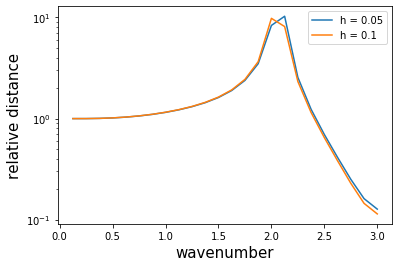

In [135]:
plt.semilogy(np.arange(0.125, 3.125, 0.125), err_005)
plt.semilogy(np.arange(0.125, 3.125, 0.125), err_01)
plt.legend(['h = 0.05', 'h = 0.1'])
plt.xlabel('wavenumber', fontsize = 15)
plt.ylabel('relative distance', fontsize = 15)
plt.savefig('relative distance: equality in maxwell case.pdf')